In [1]:
!pip install pytube

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 955.0 kB/s eta 0:00:00


# Prepare dataset

In [2]:
# !git clone https://github.com/RaivoKoot/Video-Dataset-Loading-Pytorch.git

In [3]:
!git clone https://github.com/davisvideochallenge/davis-2017.git

fatal: destination path 'davis-2017' already exists and is not an empty directory.


In [4]:
!davis-2017/data/get_davis.sh

Streaming output truncated to the last 5000 lines.
  inflating: DAVIS/JPEGImages/480p/lady-running/00027.jpg  
  inflating: DAVIS/JPEGImages/480p/lady-running/00028.jpg  
  inflating: DAVIS/JPEGImages/480p/lady-running/00029.jpg  
  inflating: DAVIS/JPEGImages/480p/lady-running/00030.jpg  
  inflating: DAVIS/JPEGImages/480p/lady-running/00031.jpg  
  inflating: DAVIS/JPEGImages/480p/lady-running/00032.jpg  
  inflating: DAVIS/JPEGImages/480p/lady-running/00033.jpg  
  inflating: DAVIS/JPEGImages/480p/lady-running/00034.jpg  
  inflating: DAVIS/JPEGImages/480p/lady-running/00035.jpg  
  inflating: DAVIS/JPEGImages/480p/lady-running/00036.jpg  
  inflating: DAVIS/JPEGImages/480p/lady-running/00037.jpg  
  inflating: DAVIS/JPEGImages/480p/lady-running/00038.jpg  
  inflating: DAVIS/JPEGImages/480p/lady-running/00039.jpg  
  inflating: DAVIS/JPEGImages/480p/lady-running/00040.jpg  
  inflating: DAVIS/JPEGImages/480p/lady-running/00041.jpg  
  inflating: DAVIS/JPEGImages/480p/lady-running/0

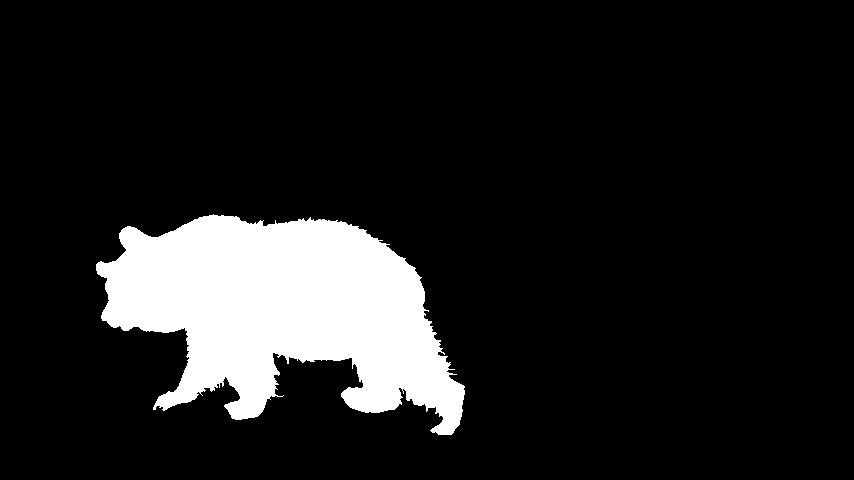

In [6]:
import cv2
from google.colab.patches import cv2_imshow
cv2_imshow((cv2.cvtColor(cv2.imread('/content/DAVIS/Annotations/480p/bear/00000.png'), cv2.COLOR_BGR2GRAY) > 1).astype(int) * 255)

In [7]:
#remove dirs where num frames do not match
import os
import os.path as path
vid_path = '/content/DAVIS/JPEGImages/480p'
mask_path = '/content/DAVIS/Annotations/480p'
annotations = []
for f in os.listdir(vid_path):
    if len(os.listdir(path.join(vid_path, f))) != len(os.listdir(path.join(mask_path, f))) or len(os.listdir(path.join(mask_path, f))) == 0:
        print('removing ', f)
        for g in os.listdir(path.join(vid_path, f)):
            os.remove(path.join(vid_path, f, g))
        for g in os.listdir(path.join(mask_path, f)):
            os.remove(path.join(mask_path, f, g))
        os.rmdir(path.join(vid_path, f))
        os.rmdir(path.join(mask_path, f))
    else:
        # print(f)
        min_frame = min(os.listdir(path.join(vid_path, f)))[:-4]
        max_frame = max(os.listdir(path.join(vid_path, f)))[:-4]
        annotations.append((f, min_frame, max_frame, 0))
print(annotations)

koala
night-race
horsejump-low
loading
stroller
rallye
breakdance
removing  orchid
dance-twirl
removing  gym
removing  salsa
removing  tractor
removing  golf
drone
paragliding
sheep
removing  girl-dog
cat-girl
hike
rollerblade
bike-packing
classic-car
judo
removing  people-sunset
breakdance-flare
bear
car-shadow
dog
dancing
shooting
snowboard
hockey
india
removing  tandem
lucia
stunt
tractor-sand
paragliding-launch
mallard-water
lindy-hop
varanus-cage
car-roundabout
lab-coat
removing  helicopter
pigs
removing  man-bike
disc-jockey
bmx-trees
skate-park
dogs-scale
motorbike
miami-surf
removing  subway
kid-football
removing  skate-jump
blackswan
drift-turn
upside-down
car-turn
scooter-board
removing  seasnake
cows
crossing
kite-walk
removing  mtb-race
removing  guitar-violin
libby
tennis
train
longboard
elephant
drift-chicane
mbike-trick
planes-water
dog-gooses
bus
motocross-bumps
removing  rollercoaster
removing  car-race
bmx-bumps
color-run
dogs-jump
rhino
kite-surf
removing  horsejump-

In [8]:
with open('/content/annotations.txt', 'w') as f:
    for ann in annotations:
        f.write(f'{ann[0]} {int(ann[1])} {int(ann[2])} {ann[3]}\n')

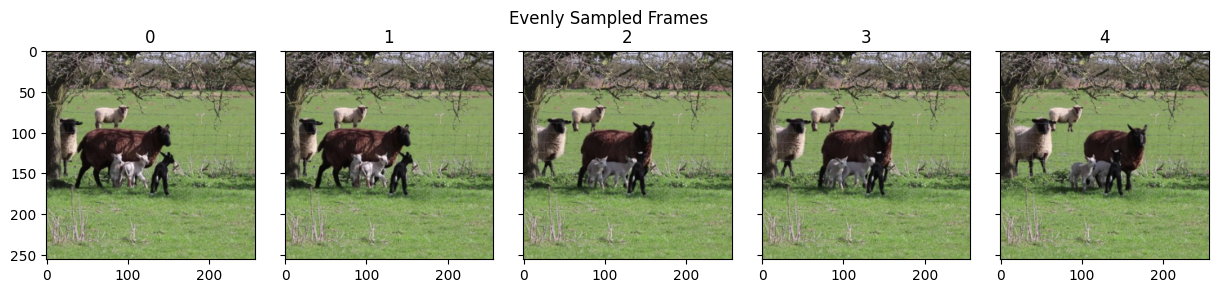

<ipython-input-1-efb3026d61cc>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torchvision.transforms.Lambda(lambda x : torch.tensor((x > 0), dtype=torch.float32)),


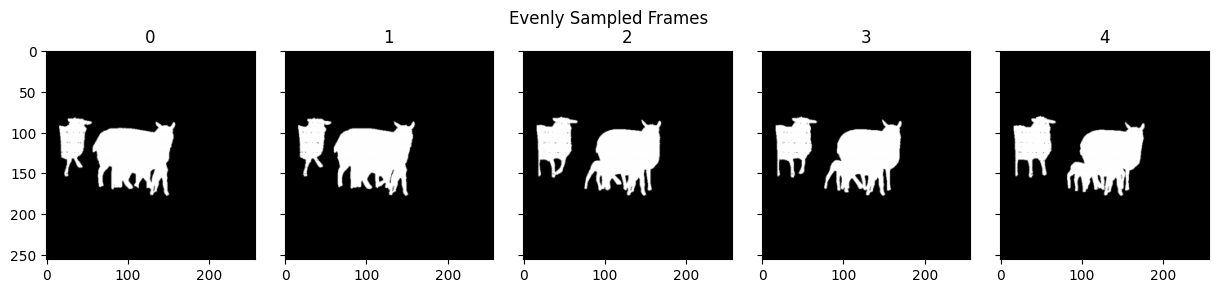

In [1]:
from video_dataset import  VideoFrameDataset, ImglistToTensor
from torchvision import transforms
import torch
import torchvision
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import os

"""
Ignore this function and look at "main" below.
"""
def plot_video(rows, cols, frame_list, plot_width, plot_height, title: str):
    fig = plt.figure(figsize=(plot_width, plot_height))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(rows, cols),  # creates 2x2 grid of axes
                     axes_pad=0.3,  # pad between axes in inch.
                     )

    for index, (ax, im) in enumerate(zip(grid, frame_list)):
        # Iterating over the grid returns the Axes.
        ax.imshow(im)
        ax.set_title(index)
    plt.suptitle(title)
    plt.show()

if __name__ == '__main__':
    """
    This demo uses the dummy dataset inside of the folder "demo_dataset".
    It is structured just like a real dataset would need to be structured.

    TABLE OF CODE CONTENTS:
    1. Minimal demo without image transforms
    2. Minimal demo without sparse temporal sampling for single continuous frame clips, without image transforms
    3. Demo with image transforms
    4. Demo 3 continued with PyTorch dataloader
    5. Demo of using a dataset where samples have multiple separate class labels

    """
    videos_root = os.path.join('/content', 'DAVIS/JPEGImages/480p')
    masks_root = os.path.join('/content', 'DAVIS/Annotations/480p')
    annotation_file = os.path.join('/content', 'annotations.txt')

    preprocess = transforms.Compose([
        ImglistToTensor(),  # list of PIL images to (FRAMES x CHANNELS x HEIGHT x WIDTH) tensor
        transforms.Resize(256),  # image batch, resize smaller edge to 299
        transforms.CenterCrop(256),  # image batch, center crop to square 299x299
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    preprocess_mask = transforms.Compose([
        ImglistToTensor(),  # list of PIL images to (FRAMES x CHANNELS x HEIGHT x WIDTH) tensor
        torchvision.transforms.Grayscale(num_output_channels=3),
        torchvision.transforms.Lambda(lambda x : torch.tensor((x > 0), dtype=torch.float32)),
        transforms.Resize(256),  # image batch, resize smaller edge to 299
        transforms.CenterCrop(256),  # image batch, center crop to square 299x299
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    def denormalize(video_tensor):
        """
        Undoes mean/standard deviation normalization, zero to one scaling,
        and channel rearrangement for a batch of images.
        args:
            video_tensor: a (FRAMES x CHANNELS x HEIGHT x WIDTH) tensor
        """
        inverse_normalize = transforms.Normalize(
            mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
            std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
        )
        return (inverse_normalize(video_tensor) * 255.).type(torch.uint8).permute(0, 2, 3, 1).numpy()

    """ DEMO 1 WITHOUT IMAGE TRANSFORMS """
    dataset = VideoFrameDataset(
        root_path=videos_root,
        annotationfile_path=annotation_file,
        num_segments=5,
        frames_per_segment=2,
        imagefile_template='{:05d}.jpg',
        transform=preprocess,
        test_mode=False
    )

    sample = dataset[10]
    frames = sample[0]  # list of PIL images
    label = sample[1]   # integer label

    plot_video(rows=1, cols=5, frame_list=denormalize(frames), plot_width=15., plot_height=3.,
               title='Evenly Sampled Frames')

    mask_dataset = VideoFrameDataset(
        root_path=masks_root,
        annotationfile_path=annotation_file,
        num_segments=5,
        frames_per_segment=2,
        imagefile_template='{:05d}.png',
        transform=preprocess_mask,
        test_mode=False
    )

    mask_sample = mask_dataset[10]
    mask_frames = mask_sample[0]  # list of PIL images
    mask_label = mask_sample[1]   # integer label

    plot_video(rows=1, cols=5, frame_list=denormalize(mask_frames), plot_width=15., plot_height=3.,
               title='Evenly Sampled Frames')


In [2]:
print(len(dataset))
print(len(dataset[0]))
print(type(dataset[0][0]))
print(dataset[0][0].shape, dataset[0][1])

90
2
<class 'torch.Tensor'>
torch.Size([10, 3, 256, 256]) 0


In [3]:
import os
from PIL import Image
import torch.nn.functional as F

import torch
from torchvision import transforms
from torchvision.io import read_video
from torch.utils.data import Dataset
import random

def resize(image, size):
    image = F.interpolate(image.unsqueeze(0), size=size, mode="nearest").squeeze(0)
    return image

def denormalize(video_tensor):
    """
    Undoes mean/standard deviation normalization, zero to one scaling,
    and channel rearrangement for a batch of images.
    args:
        video_tensor: a (FRAMES x CHANNELS x HEIGHT x WIDTH) tensor
    """
    inverse_normalize = transforms.Normalize(
        mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
        std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
    )
    return (inverse_normalize(video_tensor) * 255.).type(torch.uint8).permute(0, 2, 3, 1).numpy()


class MVSTDataset(Dataset):
    def __init__(self,cont_vids_path, cont_mask_vids_path, annotations_path, style_imgs_path, num_classes, img_size=256):

        self.preprocess = transforms.Compose([
            ImglistToTensor(),  # list of PIL images to (FRAMES x CHANNELS x HEIGHT x WIDTH) tensor
            transforms.Resize(256),  # image batch, resize smaller edge to 299
            transforms.CenterCrop(256),  # image batch, center crop to square 299x299
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        self.preprocess_mask = transforms.Compose([
            ImglistToTensor(),  # list of PIL images to (FRAMES x CHANNELS x HEIGHT x WIDTH) tensor
            torchvision.transforms.Grayscale(num_output_channels=3),
            torchvision.transforms.Lambda(lambda x : torch.tensor((x > 0), dtype=torch.float32)),
            transforms.Resize(256),  # image batch, resize smaller edge to 299
            transforms.CenterCrop(256),  # image batch, center crop to square 299x299
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        self.cont_vids_path = cont_vids_path
        self.cont_mask_vids_path = cont_mask_vids_path
        self.annotation_file = annotation_file
        self.style_imgs_path = style_imgs_path
        self.style_img_files = self.list_files(style_imgs_path)
        self.img_size = img_size
        assert(num_classes == 2)
        self.num_classes = num_classes
        self.transform = transforms.Compose([
            transforms.Resize((self.img_size,self.img_size), Image.BICUBIC),
            transforms.ToTensor()
        ])
        self.FRAME_COUNT = 100
        self.dataset = VideoFrameDataset(
            root_path=cont_vids_path,
            annotationfile_path=annotation_file,
            num_segments=5,
            frames_per_segment=2,
            imagefile_template='{:05d}.jpg',
            transform=preprocess,
            test_mode=False
        )

        self.mask_dataset = VideoFrameDataset(
            root_path=cont_mask_vids_path,
            annotationfile_path=annotation_file,
            num_segments=5,
            frames_per_segment=2,
            imagefile_template='{:05d}.png',
            transform=preprocess_mask,
            test_mode=False
        )

        self.style_dataset = torchvision.datasets.ImageFolder(self.style_imgs_path, transforms.Compose([
            transforms.Resize(256),  # image batch, resize smaller edge to 299
            transforms.CenterCrop(256),  # image batch, center crop to square 299x299
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]))

    def __len__(self):
        return len(self.dataset) * len(self.style_dataset)

    def __getitem__(self,idx):
        style_idx = idx % len(self.style_dataset)
        cont_idx = idx // len(self.style_dataset)

        cont_vid_item = self.dataset.__getitem__(cont_idx)[0]
        cont_mask_vid_item = self.mask_dataset.__getitem__(cont_idx)[0]
        style_img_item1 = self.style_dataset.__getitem__(style_idx)[0]
        style_img_item2 = self.style_dataset.__getitem__((style_idx + 1) % len(self.style_dataset))[0]

        cont_mask_vid_item = torch.unsqueeze(cont_mask_vid_item, 0) # 1xFx3x256x256

        style_img_item1 = torch.unsqueeze(style_img_item1, 0) # 1x3x256x256
        style_img_item2 = torch.unsqueeze(style_img_item2, 0) # 1x3x256x256

        return cont_vid_item, torch.cat([cont_mask_vid_item, 1-cont_mask_vid_item], dim=0), torch.cat([style_img_item1, style_img_item1], dim=0)
        # return low_cont, cont_img, style_img, low_style, mask_img


    def list_files(self, in_path):
        files = []
        for (dirpath, dirnames, filenames) in os.walk(in_path):
            files.extend(filenames)
            break
        files = sorted([os.path.join(in_path, x) for x in files])
        return files


# Masked Video Style Transfer

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import time

# Defining the global variables.


In [5]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision
from torchvision import models
from torchsummary import summary
from torchvision.models.feature_extraction import create_feature_extractor


def resize(image, size):
    image = F.interpolate(image.unsqueeze(0), size=size, mode="nearest").squeeze(0)
    return image


def calc_mean_std(feat, eps=1e-5):
    # eps is a small value added to the variance to avoid divide-by-zero.
    size = feat.size()
    assert (len(size) == 4)
    N, C = size[:2]
    feat_var = feat.view(N, C, -1).var(dim=2) + eps
    feat_std = feat_var.sqrt().view(N, C, 1, 1)
    feat_mean = feat.view(N, C, -1).mean(dim=2).view(N, C, 1, 1)
    return feat_mean, feat_std


def st_ada_in(style_features, content_cur_masked_features, content_prev_masked_features, alpha = 0.1):
    # print('#', style_features.shape, content_cur_masked_features.shape, content_prev_masked_features.shape) #BxCxSxS

    x_cur_mean, x_cur_std = calc_mean_std(content_cur_masked_features)
    x_prev_mean, x_prev_std = calc_mean_std(content_prev_masked_features)

    # print('#', type(alpha), type(x_cur_mean), type(x_prev_mean))
    combined_mean = (1-alpha) * x_cur_mean + alpha * x_prev_mean
    combined_std = (1-alpha) * x_cur_std + alpha * x_prev_std

    style_mean, style_std = calc_mean_std(style_features)

    result = style_std * (content_cur_masked_features - combined_mean) / combined_std + style_mean
    # print('#', x_cur_mean.shape, result.shape)
    return result


def get_VGG_feature_extractor():
    # vgg_layer_names = ["block1_conv1", "block2_conv1", "block3_conv1", "block4_conv1"]
    # vgg_layer_names = ["ReLU-2", "ReLU-7", "ReLU-12", "ReLU-21"]
    vgg_fixed = torchvision.models.vgg19(weights='IMAGENET1K_V1')
    for param in vgg_fixed.parameters():
        param.requires_grad = False

    # train_nodes, eval_nodes = get_graph_node_names(vgg_fixed)
    # print(train_nodes, eval_nodes)

    # To specify the nodes you want to extract, you could select the final node
    # that appears in each of the main layers:
    return_nodes = {
        # node_name: user-specified key for output dict
        'features.2': 'layer1',
        'features.7': 'layer2',
        'features.12': 'layer3',
        'features.21': 'layer4',
    }

    return create_feature_extractor(vgg_fixed, return_nodes=return_nodes)


class SpatioTemporalTransferModel(nn.Module):
    def __init__(self, vgg_feature_extractor):
        super(SpatioTemporalTransferModel, self).__init__()
        self.vgg_feature_extractor = vgg_feature_extractor

        #define splatting blocks' layers
        self.sb_11 = ConvBlock(in_channels=64, out_channels=8, kernel_size=3,  padding="same", stride=2)
        self.sb_12 = ConvBlock(in_channels=8, out_channels=8, kernel_size=3,  padding="same", stride=1)
        self.sb_13 = ConvBlock(in_channels=8, out_channels=8, kernel_size=3,  padding="same", stride=1)
        self.sb_1_short = ConvBlock(in_channels=128, out_channels=8, kernel_size=3,  padding="same", stride=1)

        self.sb_21 = ConvBlock(in_channels=8, out_channels=16, kernel_size=3,  padding="same", stride=2)
        self.sb_22 = ConvBlock(in_channels=16, out_channels=16, kernel_size=3,  padding="same", stride=1)
        self.sb_23 = ConvBlock(in_channels=16, out_channels=16, kernel_size=3,  padding="same", stride=1)
        self.sb_2_short = ConvBlock(in_channels=256, out_channels=16, kernel_size=3,  padding="same", stride=1)

        self.sb_31 = ConvBlock(in_channels=16, out_channels=32, kernel_size=3,  padding="same", stride=2)
        self.sb_32 = ConvBlock(in_channels=32, out_channels=32, kernel_size=3,  padding="same", stride=1)
        self.sb_33 = ConvBlock(in_channels=32, out_channels=32, kernel_size=3,  padding="same", stride=1)
        self.sb_3_short = ConvBlock(in_channels=512, out_channels=32, kernel_size=3,  padding="same", stride=1)

        self.l_1 = ConvBlock(in_channels=32, out_channels=64, kernel_size=3,  padding="same", stride=2)
        self.l_2 = ConvBlock(in_channels=64, out_channels=64, kernel_size=3,  padding="same", stride=1)

        self.gp_1 = ConvBlock(in_channels=64, out_channels=64, kernel_size=3,  padding="same", stride=1)

        self.gp_2 = ConvBlock(in_channels=64, out_channels=96, kernel_size=1,  padding="same", stride=1) #TODO : activation none?
        return

    def forward(self, style, content, mask, mask_prev, cpe_1, cpe_2, cpe_3, cpe_4, adap_1, adap_2, adap_3):
        # Encode the style and content image.

        style_encoded_dict = self.vgg_feature_extractor(style)
        style_encoded = [style_encoded_dict[f'layer{i}'] for i in range(1,5)]

        content_encoded_dict = self.vgg_feature_extractor(content * mask)
        content_encoded = [content_encoded_dict[f'layer{i}'] for i in range(1,5)]

        # Compute the AdaIN target feature maps.
        st_ada_in_outputs = []
        # skip block1_conv1
        skipCount = 1
        count = 0
        content_prev_encoded = [cpe_1, cpe_2, cpe_3, cpe_4]
        for encoded_features in zip(style_encoded, content_encoded, content_prev_encoded):
            # print('! ', count)
            if count < skipCount:
                count += 1
                continue
            # TODO : manage prev features and consider mask shape
            st_ada_in_output = st_ada_in(encoded_features[0], encoded_features[1], encoded_features[2], alpha = 0.1)
            st_ada_in_outputs.append(st_ada_in_output)

        temp_content = self.sb_11(content_encoded[0]) #input is c_in
        temp_style = self.sb_11(style_encoded[0]) #input is s_in
        #TODO corresponding prev variables and mask
        temp_content_stylized = st_ada_in(temp_style, temp_content, adap_1, alpha = 0.1)
        adap_1 = temp_content.clone().detach()
        temp_content_stylized = temp_content_stylized + self.sb_1_short(st_ada_in_outputs[0])
        temp_content_stylized = self.sb_12(temp_content_stylized)
        temp_content_stylized = self.sb_13(temp_content_stylized) #c_out
        # print('here', temp_style.shape)
        temp_style = self.sb_13(temp_style) #s_out

        temp_content = self.sb_21(temp_content_stylized) #input is c_in
        temp_style = self.sb_21(temp_style) #input is s_in
        #TODO corresponding prev variables and mask
        temp_content_stylized = st_ada_in(temp_style, temp_content, adap_2, alpha = 0.1)
        adap_2 = temp_content.clone().detach()
        temp_content_stylized = temp_content_stylized + self.sb_2_short(st_ada_in_outputs[1])
        temp_content_stylized = self.sb_22(temp_content_stylized)
        temp_content_stylized = self.sb_23(temp_content_stylized) #c_out
        temp_style = self.sb_23(temp_style) #s_out

        temp_content = self.sb_31(temp_content_stylized) #input is c_in
        temp_style = self.sb_31(temp_style) #input is s_in
        #TODO corresponding prev variables and mask
        temp_content_stylized = st_ada_in(temp_style, temp_content, adap_3, alpha = 0.1)
        adap_3 = temp_content.clone().detach()
        temp_content_stylized = temp_content_stylized + self.sb_3_short(st_ada_in_outputs[2])
        temp_content_stylized = self.sb_32(temp_content_stylized)
        temp_content_stylized = self.sb_33(temp_content_stylized) #c_out
        temp_style = self.sb_33(temp_style) #s_out

        temp_content_stylized = self.l_1(temp_content_stylized)
        temp_content_stylized = self.l_2(temp_content_stylized) #stylized_features

        #grid prediction
        bilateral_grid = self.gp_1(temp_content_stylized)
        bilateral_grid = self.gp_2(bilateral_grid)

        content_prev_encoded = content_encoded.copy()

        return bilateral_grid, content_prev_encoded[0], content_prev_encoded[1], content_prev_encoded[2], content_prev_encoded[3], adap_1, adap_2, adap_3


class SoftGridMask(nn.Module):
    def __init__(self):
        super(SoftGridMask, self).__init__()

    def create_soft_grid_mask(self, z, M_px, w, h, W, H, D):
        #TODO check reduce_sum against algo
        M_grid = torch.tensor(np.zeros((D, W, H)), dtype=torch.float32)
        # print((z * M_px * D).shape)
        z_D = torch.floor((z * M_px) * D)
        s_w, s_h = w//W, h//H

        for x in range(W):
            for y in range(H):
                patch = z_D[x * s_w : (x + 1) * s_w, y*s_h:(y+1)*s_h]
                M_grid[:,x,y] = torch.sum(torch.where(patch > 0, patch, torch.zeros_like(patch)))
                for d in range(D):
                    if torch.any(patch == d):
                        M_grid[d,x,y] = torch.sum(torch.where(patch == d, patch, torch.zeros_like(patch)))
        M_grid = M_grid / (s_w * s_h)
        return M_grid

    def forward(self, z, M_px, w, h, W, H, D):
        #TODO : use create mask function
        return self.create_soft_grid_mask(z, M_px, w, h, W, H, D)


class GridBlender(nn.Module):
    def __init__(self):
        super(GridBlender, self).__init__()

    def forward(self, grids, soft_grid_mask):
        #TODO : use grid blending function
        out = torch.zeros_like(grids[0])
        for g in grids:
            out = torch.add(out, g)
        return out
#########################################################################################################
class MaskedVideoStyleTransfer(nn.Module):
    def __init__(self, slice, apply):
        super(MaskedVideoStyleTransfer, self).__init__()
        self.vgg_feature_extractor = get_VGG_feature_extractor()
        self.spatio_temporal_model = SpatioTemporalTransferModel(self.vgg_feature_extractor)
        self.grid_blender = GridBlender()
        self.guide = GuideNN()
        self.slice = slice
        self.apply_coeffs = apply
        self.soft_grid_mask = SoftGridMask()



    def forward(self, content, mask_cur_list, style_list, content_prev, mask_prev_list, cpe_1_all, cpe_2_all, cpe_3_all, cpe_4_all, adap_1_all, adap_2_all, adap_3_all):
        # model : torch.Size([2, 3, 256, 256]) torch.Size([2, 2, 3, 256, 256]) torch.Size([2, 2, 3, 256, 256]) torch.Size([2, 3, 256, 256]) torch.Size([2, 2, 3, 256, 256]) torch.Size([2, 2, 64, 224, 224]) torch.Size([2, 2, 128, 112, 112]) torch.Size([2, 2, 256, 56, 56]) torch.Size([2, 2, 512, 28, 28]) torch.Size([2, 2, 8, 112, 112]) torch.Size([2, 2, 16, 56, 56]) torch.Size([2, 2, 32, 28, 28])
        # print('model :', content.shape, mask_cur_list.shape, style_list.shape, content_prev.shape, mask_prev_list.shape, cpe_1_all.shape, cpe_2_all.shape, cpe_3_all.shape, cpe_4_all.shape, adap_1_all.shape, adap_2_all.shape, adap_3_all.shape)

        bilateral_grid_list = []
        for classId in range(mask_cur_list.shape[1]):
            bilateral_grid, cpe_1_, cpe_2_, cpe_3_, cpe_4_, adap_1, adap_2, adap_3 = self.spatio_temporal_model(style_list[:,classId,:,:,:], content, mask_cur_list[:,classId,:,:,:], mask_prev_list[:,classId,:,:,:], cpe_1_all[:,classId,:,:,:], cpe_2_all[:,classId,:,:,:], cpe_3_all[:,classId,:,:,:], cpe_4_all[:,classId,:,:,:], adap_1_all[:, classId, :, :, :], adap_2_all[:, classId, :, :, :], adap_3_all[:, classId, :, :, :])

            cpe_1_all[:,classId, :, :, :], cpe_2_all[:,classId, :, :, :], cpe_3_all[:,classId, :, :, :], cpe_4_all[:,classId, :, :, :], adap_1_all[:, classId, :, :, :], adap_2_all[:, classId, :, :, :], adap_3_all[:, classId, :, :, :] = cpe_1_, cpe_2_, cpe_3_, cpe_4_, adap_1, adap_2, adap_3

            bilateral_grid_list.append(bilateral_grid)

        guide = self.guide(content)
        soft_grid_mask = self.soft_grid_mask(guide, mask_cur_list[0], 256, 256, 32, 32, 96)
        #TODO: handle multiple masks, one for each class
        blended_grid = self.grid_blender(bilateral_grid_list, soft_grid_mask)
        blended_grid_ = blended_grid.reshape(blended_grid.shape[0],12,-1,blended_grid.shape[-2],blended_grid.shape[-1])
        slice_coeffs = self.slice(blended_grid_, guide)
        output = self.apply_coeffs(slice_coeffs, content)

        #TODO : loss calculation, gradient calculation, backpropagation
        return output, blended_grid, soft_grid_mask, guide, cpe_1_all, cpe_2_all, cpe_3_all, cpe_4_all, adap_1_all, adap_2_all, adap_3_all
########################################################################################################

class LaplacianRegularizer3D(nn.Module):
    def __init__(self):
        super(LaplacianRegularizer3D, self).__init__()
        self.mse_loss = torch.nn.MSELoss(reduction='sum')

    def forward(self, f):
        loss = 0.
        # f: [B, 12, 8, H, W]
        f = f.reshape(f.shape[0],12,8,f.shape[2],f.shape[-1])
        B, C, D, H, W = f.shape
        for k in range(D):
            for i in range(H):
                for j in range(W):
                    front = max(k - 1, 0)
                    back = min(k + 1, D - 1)
                    up = max(i - 1, 0)
                    down = min(i + 1, H - 1)
                    left = max(j - 1, 0)
                    right = min(j + 1, W - 1)
                    term = f[:, :, k, i, j].view(B, C, 1, 1, 1).expand(B, C, back - front + 1, down - up + 1, right - left + 1)
                    loss += self.mse_loss(term, f[:, :, front:back + 1, up:down + 1, left:right + 1])
        return loss


class Slice(nn.Module):
    def __init__(self):
        super(Slice, self).__init__()

    def forward(self, bilateral_grid, guidemap):
        device = bilateral_grid.get_device()

        N, _, H, W = guidemap.shape
        hg, wg = torch.meshgrid([torch.arange(0, H), torch.arange(0, W)]) # [0,511] HxW
        if device >= 0:
            hg = hg.to(device)
            wg = wg.to(device)
        hg = hg.float().repeat(N, 1, 1).unsqueeze(3) / (H-1) * 2 - 1 # norm to [-1,1] NxHxWx1
        wg = wg.float().repeat(N, 1, 1).unsqueeze(3) / (W-1) * 2 - 1 # norm to [-1,1] NxHxWx1
        guidemap = guidemap.permute(0,2,3,1).contiguous()
        guidemap_guide = torch.cat([wg, hg, guidemap], dim=3).unsqueeze(1) # Nx1xHxWx3
        coeff = F.grid_sample(bilateral_grid, guidemap_guide)
        return coeff.squeeze(2)


class ApplyCoeffs(nn.Module):
    def __init__(self):
        super(ApplyCoeffs, self).__init__()
        self.degree = 3

    def forward(self, coeff, full_res_input):

        '''
            Affine:
            r = a11*r + a12*g + a13*b + a14
            g = a21*r + a22*g + a23*b + a24
            ...
        '''

        R = torch.sum(full_res_input * coeff[:, 0:3, :, :], dim=1, keepdim=True) + coeff[:, 3:4, :, :]
        G = torch.sum(full_res_input * coeff[:, 4:7, :, :], dim=1, keepdim=True) + coeff[:, 7:8, :, :]
        B = torch.sum(full_res_input * coeff[:, 8:11, :, :], dim=1, keepdim=True) + coeff[:, 11:12, :, :]

        return torch.cat([R, G, B], dim=1)


class GuideNN(nn.Module):
    def __init__(self, params=None):
        super(GuideNN, self).__init__()
        self.params = params
        self.conv1 = ConvBlock(3, 16, kernel_size=1, padding=0, batch_norm=False)
        self.conv2 = ConvBlock(16, 1, kernel_size=1, padding=0, activation=nn.Tanh)

    def forward(self, x):
        return self.conv2(self.conv1(x))


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding="same", stride=1, use_bias=True, activation=nn.ReLU,
                 batch_norm=False):
        super(ConvBlock, self).__init__()
        reflection_padding = kernel_size // 2 # same dimension after padding
        self.reflection_pad = nn.ReflectionPad2d(reflection_padding)
        self.conv = nn.Conv2d(int(in_channels), int(out_channels), kernel_size, stride=stride, bias=use_bias)
        self.activation = activation() if activation else None
        self.bn = nn.BatchNorm2d(out_channels) if batch_norm else None

    def forward(self, x):
        x = self.reflection_pad(x)
        x = self.conv(x)
        if self.bn:
            x = self.bn(x)
        if self.activation:
            x = self.activation(x)
        return x


In [6]:
stm = SpatioTemporalTransferModel(get_VGG_feature_extractor())
V = 256
D = 224
temp = np.ones((1,3,V,V))
temp_style = np.ones((1,3,V,V))
temp_mask = np.ones((1,3,V,V))
# print(temp.shape)

a,b1, b2, b3, b4,c,d,e = stm.forward(torch.tensor(temp_style, dtype=torch.float32), torch.tensor(temp, dtype=torch.float32),
            torch.tensor(temp_mask, dtype=torch.float32), torch.tensor(temp_mask, dtype=torch.float32), torch.tensor(np.zeros((1, 64, 256, 256)), dtype=torch.float32), torch.tensor(np.zeros((1, 128, 112, 112)), dtype=torch.float32), torch.tensor(np.zeros((1, 256, 64, 64)), dtype=torch.float32), torch.tensor(np.zeros((1, 512, 32, 32)), dtype=torch.float32),
            torch.tensor(np.zeros((1, 8, 128, 128)), dtype=torch.float32), torch.tensor(np.zeros((1, 16, 64, 64)), dtype=torch.float32),
            torch.tensor(np.zeros((1,  32, 32, 32)), dtype=torch.float32))
print(a.shape, b1.shape, b2.shape, b3.shape, b4.shape, c.shape, d.shape, e.shape)

torch.Size([1, 96, 16, 16]) torch.Size([1, 64, 256, 256]) torch.Size([1, 128, 128, 128]) torch.Size([1, 256, 64, 64]) torch.Size([1, 512, 32, 32]) torch.Size([1, 8, 128, 128]) torch.Size([1, 16, 64, 64]) torch.Size([1, 32, 32, 32])


In [7]:
g = GuideNN()
z = g(torch.tensor(np.zeros((1, 3, 256, 256)), dtype=torch.float32))
print(z.shape)

torch.Size([1, 1, 256, 256])


In [8]:
sgm = SoftGridMask()
sm = sgm.create_soft_grid_mask(z, torch.tensor(np.zeros((1, 1, 256, 256)), dtype=torch.float32), 256, 256, 16, 16, 96)
print(sm.shape)

torch.Size([96, 16, 16])


In [9]:
slice = Slice()
slice_coeffs = slice(a.reshape(a.shape[0],12,-1,a.shape[-2],a.shape[-1]), z)
print(slice_coeffs.shape)

torch.Size([1, 12, 256, 256])


/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4316: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


In [10]:
apply = ApplyCoeffs()
apply_coeffs = apply(slice_coeffs, torch.tensor(temp, dtype=torch.float32))
print(apply_coeffs.shape)

torch.Size([1, 3, 256, 256])


In [11]:
gb = GridBlender()
bg = gb([torch.tensor(np.zeros((1, 12, 8, 16, 16)), dtype=torch.float32), torch.tensor(np.ones((1, 12, 8, 16, 16)), dtype=torch.float32)], torch.tensor(np.zeros((1, 12, 8, 16, 16)), dtype=torch.float32))
print(bg.shape)

torch.Size([1, 12, 8, 16, 16])


In [12]:
mvs = MaskedVideoStyleTransfer(slice, apply)
out = mvs.forward(torch.tensor(np.zeros((1, 3, 256, 256)), dtype=torch.float32), torch.tensor(np.zeros((1, 2, 3, 256, 256)), dtype=torch.float32),
                  torch.tensor(np.zeros((1, 2, 3, 256, 256)), dtype=torch.float32), torch.tensor(np.zeros((1, 3, 256, 256)), dtype=torch.float32),
                  torch.tensor(np.zeros((1, 2, 3, 256, 256)), dtype=torch.float32), torch.tensor(np.zeros((1, 2, 64, 256, 256)), dtype=torch.float32),
                  torch.tensor(np.zeros((1, 2, 128, 128, 128)), dtype=torch.float32), torch.tensor(np.zeros((1, 2, 256, 64, 64)), dtype=torch.float32),
                  torch.tensor(np.zeros((1, 2, 512, 32, 32)), dtype=torch.float32), torch.tensor(np.zeros((1, 2, 8, 128, 128)), dtype=torch.float32),
                  torch.tensor(np.zeros((1, 2, 16, 64, 64)), dtype=torch.float32), torch.tensor(np.zeros((1, 2, 32, 32, 32)), dtype=torch.float32))
print(out[0].shape)

torch.Size([1, 3, 256, 256])


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4316: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


In [13]:
def warp_with_flow(x, flo):
    """
    x: [B, C, H, W] (prev_image)
    flo: [B, 2, H, W] flow

    """
    B, C, H, W = x.size()
    # mesh grid
    xx = torch.arange(0, W).view(1 ,-1).repeat(H ,1)
    yy = torch.arange(0, H).view(-1 ,1).repeat(1 ,W)
    xx = xx.view(1 ,1 ,H ,W).repeat(B ,1 ,1 ,1)
    yy = yy.view(1 ,1 ,H ,W).repeat(B ,1 ,1 ,1)
    grid = torch.cat((xx ,yy), 1).float()

    if x.is_cuda:
        grid = grid.cuda()
    vgrid = torch.autograd.Variable(grid) + flo

    # scale grid to [-1,1]
    vgrid[: ,0 ,: ,:] = 2.0 *vgrid[: ,0 ,: ,:].clone() / max( W -1 ,1 ) -1.0
    vgrid[: ,1 ,: ,:] = 2.0 *vgrid[: ,1 ,: ,:].clone() / max( H -1 ,1 ) -1.0

    vgrid = vgrid.permute(0, 2, 3, 1)
    flo = flo.permute(0, 2, 3, 1)
    output = F.grid_sample(x, vgrid)
    mask = torch.autograd.Variable(torch.ones(x.size()))
    mask = F.grid_sample(mask, vgrid)

    mask[mask <0.9999] = 0
    mask[mask >0] = 1

    return output*mask

In [19]:

mse_loss = nn.MSELoss()

def calc_content_loss(input, target):
    #inputs are extracted layer features of images
    assert (input.size() == target.size())
    assert (target.requires_grad is False)
    return mse_loss(input, target)

def calc_style_loss(input, target):
    #inputs are extracted layer features of images
    assert (input.size() == target.size())
    assert (target.requires_grad is False)
    input_mean, input_std = calc_mean_std(input)
    target_mean, target_std = calc_mean_std(target)
    return mse_loss(input_mean, target_mean) + \
            mse_loss(input_std, target_std)

def content_and_style_loss( content_feat, out_content_feat,  style_feats, out_style_feats, alpha=1.0):
    assert 0 <= alpha <= 1

    loss_c = calc_content_loss(out_content_feat, content_feat)
    loss_s = calc_style_loss(out_style_feats[0], style_feats[0])
    for i in range(1, 4):
        loss_s += calc_style_loss(out_style_feats[i], style_feats[i])
    return loss_c, loss_s

def lumin_loss(guide, content_grayscale):
    assert (guide.size() == content_grayscale.size())
    assert (content_grayscale.requires_grad is False)
    return mse_loss(guide, content_grayscale)

def mask_loss(input, target):
    assert (input.size() == target.size())
    assert (target.requires_grad is False)
    return mse_loss(input, target)

def temporal_loss(flo, output_cur, output_prev):
    assert (output_cur.size() == output_prev.size())
    assert (output_prev.requires_grad is False)
    warped_output = warp_with_flow(output_prev, flo)
    return mse_loss(output_cur, warped_output)

# Train and save model

In [33]:
from torch.utils.data import DataLoader
from torch.optim import SGD, Adam
from torchvision.models.optical_flow import raft_small
from torchvision.models.optical_flow import Raft_Small_Weights
import sys

def train(args):
    cont_vids_path = args['cont_vids_path'] #/vids
    cont_mask_vids_path = args['cont_mask_vids_path'] #/mask_vids
    annotations_path = args['annotations_path'] #/annotations_path
    style_imgs_path = args['style_imgs_path'] #/style_images
    num_classes = args['num_classes'] #/num_classes
    batch_size = args['batch_size']
    vgg_checkpoint = args['vgg_checkpoint']
    output_vid_path = args['output_vid_path']
    log_interval = args['log_interval']
    ckpt_interval = args['ckpt_interval']

    # set dataset
    device = torch.device("cpu")
    train_dataset = MVSTDataset(cont_vids_path, cont_mask_vids_path, annotations_path, style_imgs_path, num_classes, img_size=256)
    train_loader = DataLoader(train_dataset, batch_size=batch_size)

    flow_model = raft_small(weights=Raft_Small_Weights.DEFAULT, progress=False).to(device)
    flow_model = flow_model.eval()
    vgg_feature_extractor = get_VGG_feature_extractor()
    slice = Slice()
    apply = ApplyCoeffs()
    model = MaskedVideoStyleTransfer(slice, apply).to(device)
    optimizer = Adam(model.parameters(), lr=1e-4)
    L_loss = LaplacianRegularizer3D()
    epochs = 2
    batch_done = 0
    # training iteration
    for e in range(epochs):
        cpe_1_all = torch.tensor(np.zeros((batch_size, num_classes, 64, 256, 256)), dtype=torch.float32)
        cpe_2_all = torch.tensor(np.zeros((batch_size, num_classes, 128, 128, 128)), dtype=torch.float32)
        cpe_3_all = torch.tensor(np.zeros((batch_size, num_classes, 256, 64, 64)), dtype=torch.float32)
        cpe_4_all = torch.tensor(np.zeros((batch_size, num_classes, 512, 32, 32)), dtype=torch.float32)
        adap_1_all = torch.tensor(np.zeros((batch_size, num_classes, 8, 128, 128)), dtype=torch.float32)
        adap_2_all = torch.tensor(np.zeros((batch_size, num_classes, 16, 64, 64)), dtype=torch.float32)
        adap_3_all = torch.tensor(np.zeros((batch_size, num_classes, 32, 32, 32)), dtype=torch.float32)
        output_prev = torch.tensor(np.zeros((batch_size, 3, 256, 256)), dtype=torch.float32)
        model.train()
        for i ,(cont_imgs, mask_img_lists, style_img_lists) in enumerate(train_loader):
            #cont_img is B x num_frames x 3 x 256 x 256
            # print(cont_imgs.shape, mask_img_lists.shape, style_img_lists.shape)
            for frame_idx in range(cont_imgs.shape[1]):
                cont_img = cont_imgs[:,frame_idx,:,:,:].to(device)
                mask_img_list = mask_img_lists[:,:,frame_idx,:,:,:].to(device)
                style_img_list = style_img_lists.to(device)
                # print('training: ', i, cont_img.shape, (mask_img_list.shape), (style_img_list.shape))

                all_cont_feats = vgg_feature_extractor(cont_img)
                cont_feat = all_cont_feats['layer4']
                all_style_feats_list = [vgg_feature_extractor(style_img_list[:,i,:,:,:]) for i in range(num_classes)]
                style_feat_list = [all_style_feats_list[i]['layer4'] for i in range(num_classes)]

                #TODO
                output, blended_grid, soft_grid_mask, guide, cpe_1_all, cpe_2_all, cpe_3_all, cpe_4_all, adap_1_all, adap_2_all, adap_3_all = model(cont_img,mask_img_list, style_img_list, cont_img, mask_img_list, cpe_1_all, cpe_2_all, cpe_3_all, cpe_4_all, adap_1_all, adap_2_all, adap_3_all)

                all_out_feats = vgg_feature_extractor(output)
                loss_c_agg = 0
                loss_s_agg = 0
                for i in range(num_classes):
                    loss_c,loss_s  = content_and_style_loss(cont_feat, all_out_feats['layer4'], [all_style_feats_list[i][f'layer{j+1}'] for j in range(4)], [all_out_feats[f'layer{j+1}'] for j in range(4)])
                    loss_c_agg += loss_c
                    loss_s_agg += loss_s

                loss_r = L_loss(blended_grid)
                loss_z = lumin_loss(guide, torchvision.transforms.Grayscale(num_output_channels=1)(cont_img))
                # soft_grid_mask_ = soft_grid_mask.reshape(soft_grid_mask.shape[0],12,-1,soft_grid_mask.shape[-2],soft_grid_mask.shape[-1])
                # loss_m = mask_loss(apply(slice(soft_grid_mask_, guide), mask_img_list), torch.cat([mask_img_list, mask_img_list, mask_img_list], dim=1))
                loss_m = 0
                list_of_flows = flow_model(output.to(device), output_prev.to(device)) #last one in the list is the most accurate

                loss_t = temporal_loss(list_of_flows[-1], output, output_prev)

                total_loss = 0.2 * loss_c + loss_s + 0.02 * loss_r + 5 * loss_m + 1.5 * loss_z + 1000 * loss_t

                total_loss.backward()
                optimizer.step()

                # Print log
                print(
                    "\r[Epoch %d/%d] [Batch %d/%d] [C loss: %f, S loss: %f, R loss: %f, total loss: %f]"
                    % (
                        e,
                        epochs,
                        i,
                        len(train_loader),
                        loss_c.item(),
                        loss_s.item(),
                        loss_r.item(),
                        total_loss.item(),
                    )
                )
                # if (batch_done+1) % log_interval == 0:
                #     batch = [cont_img,low_cont,style_img,low_style]
                #     sample_image(net, model, batch, e,output_file)

                # if (batch_done + 1) % ckpt_interval == 0:
                #     model.eval().cpu()
                #     ckpt_model_filename = "ckpt_" + str(e) + '_' + str(batch_done) + ".pth"
                #     ckpt_model_path = os.path.join('./checkpoints', ckpt_model_filename)
                #     torch.save(model.state_dict(), ckpt_model_path)
                #     model.to(device).train()
            batch_done += 1
    return

In [ ]:
args = {}
args['cont_vids_path'] = '/content/DAVIS/JPEGImages/480p' #/vids
args['cont_mask_vids_path'] = '/content/DAVIS/Annotations/480p' #/mask_vids
args['annotations_path'] = '/content/annotations.txt' #/mask_vids
args['style_imgs_path'] = '/content/style' #/style_images
args['num_classes'] = 2
args['batch_size'] = 1
args['vgg_checkpoint'] = '/content/checkpoints'
args['output_vid_path'] = '/content/output'
args['log_interval'] = 1
args['ckpt_interval'] = 1

train(args)


<ipython-input-1-efb3026d61cc>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torchvision.transforms.Lambda(lambda x : torch.tensor((x > 0), dtype=torch.float32)),
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4316: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


[Epoch 0/2] [Batch 1/540] [C loss: 39.828625, S loss: 23.590549, R loss: 5371.086426, total loss: 208.794342]
[Epoch 0/2] [Batch 1/540] [C loss: 41.257393, S loss: 24.695730, R loss: 4994.392090, total loss: 198.954865]
[Epoch 0/2] [Batch 1/540] [C loss: 45.485790, S loss: 25.242054, R loss: 4810.514160, total loss: 185.093231]


# Visualize results

NameError: name 'np' is not defined

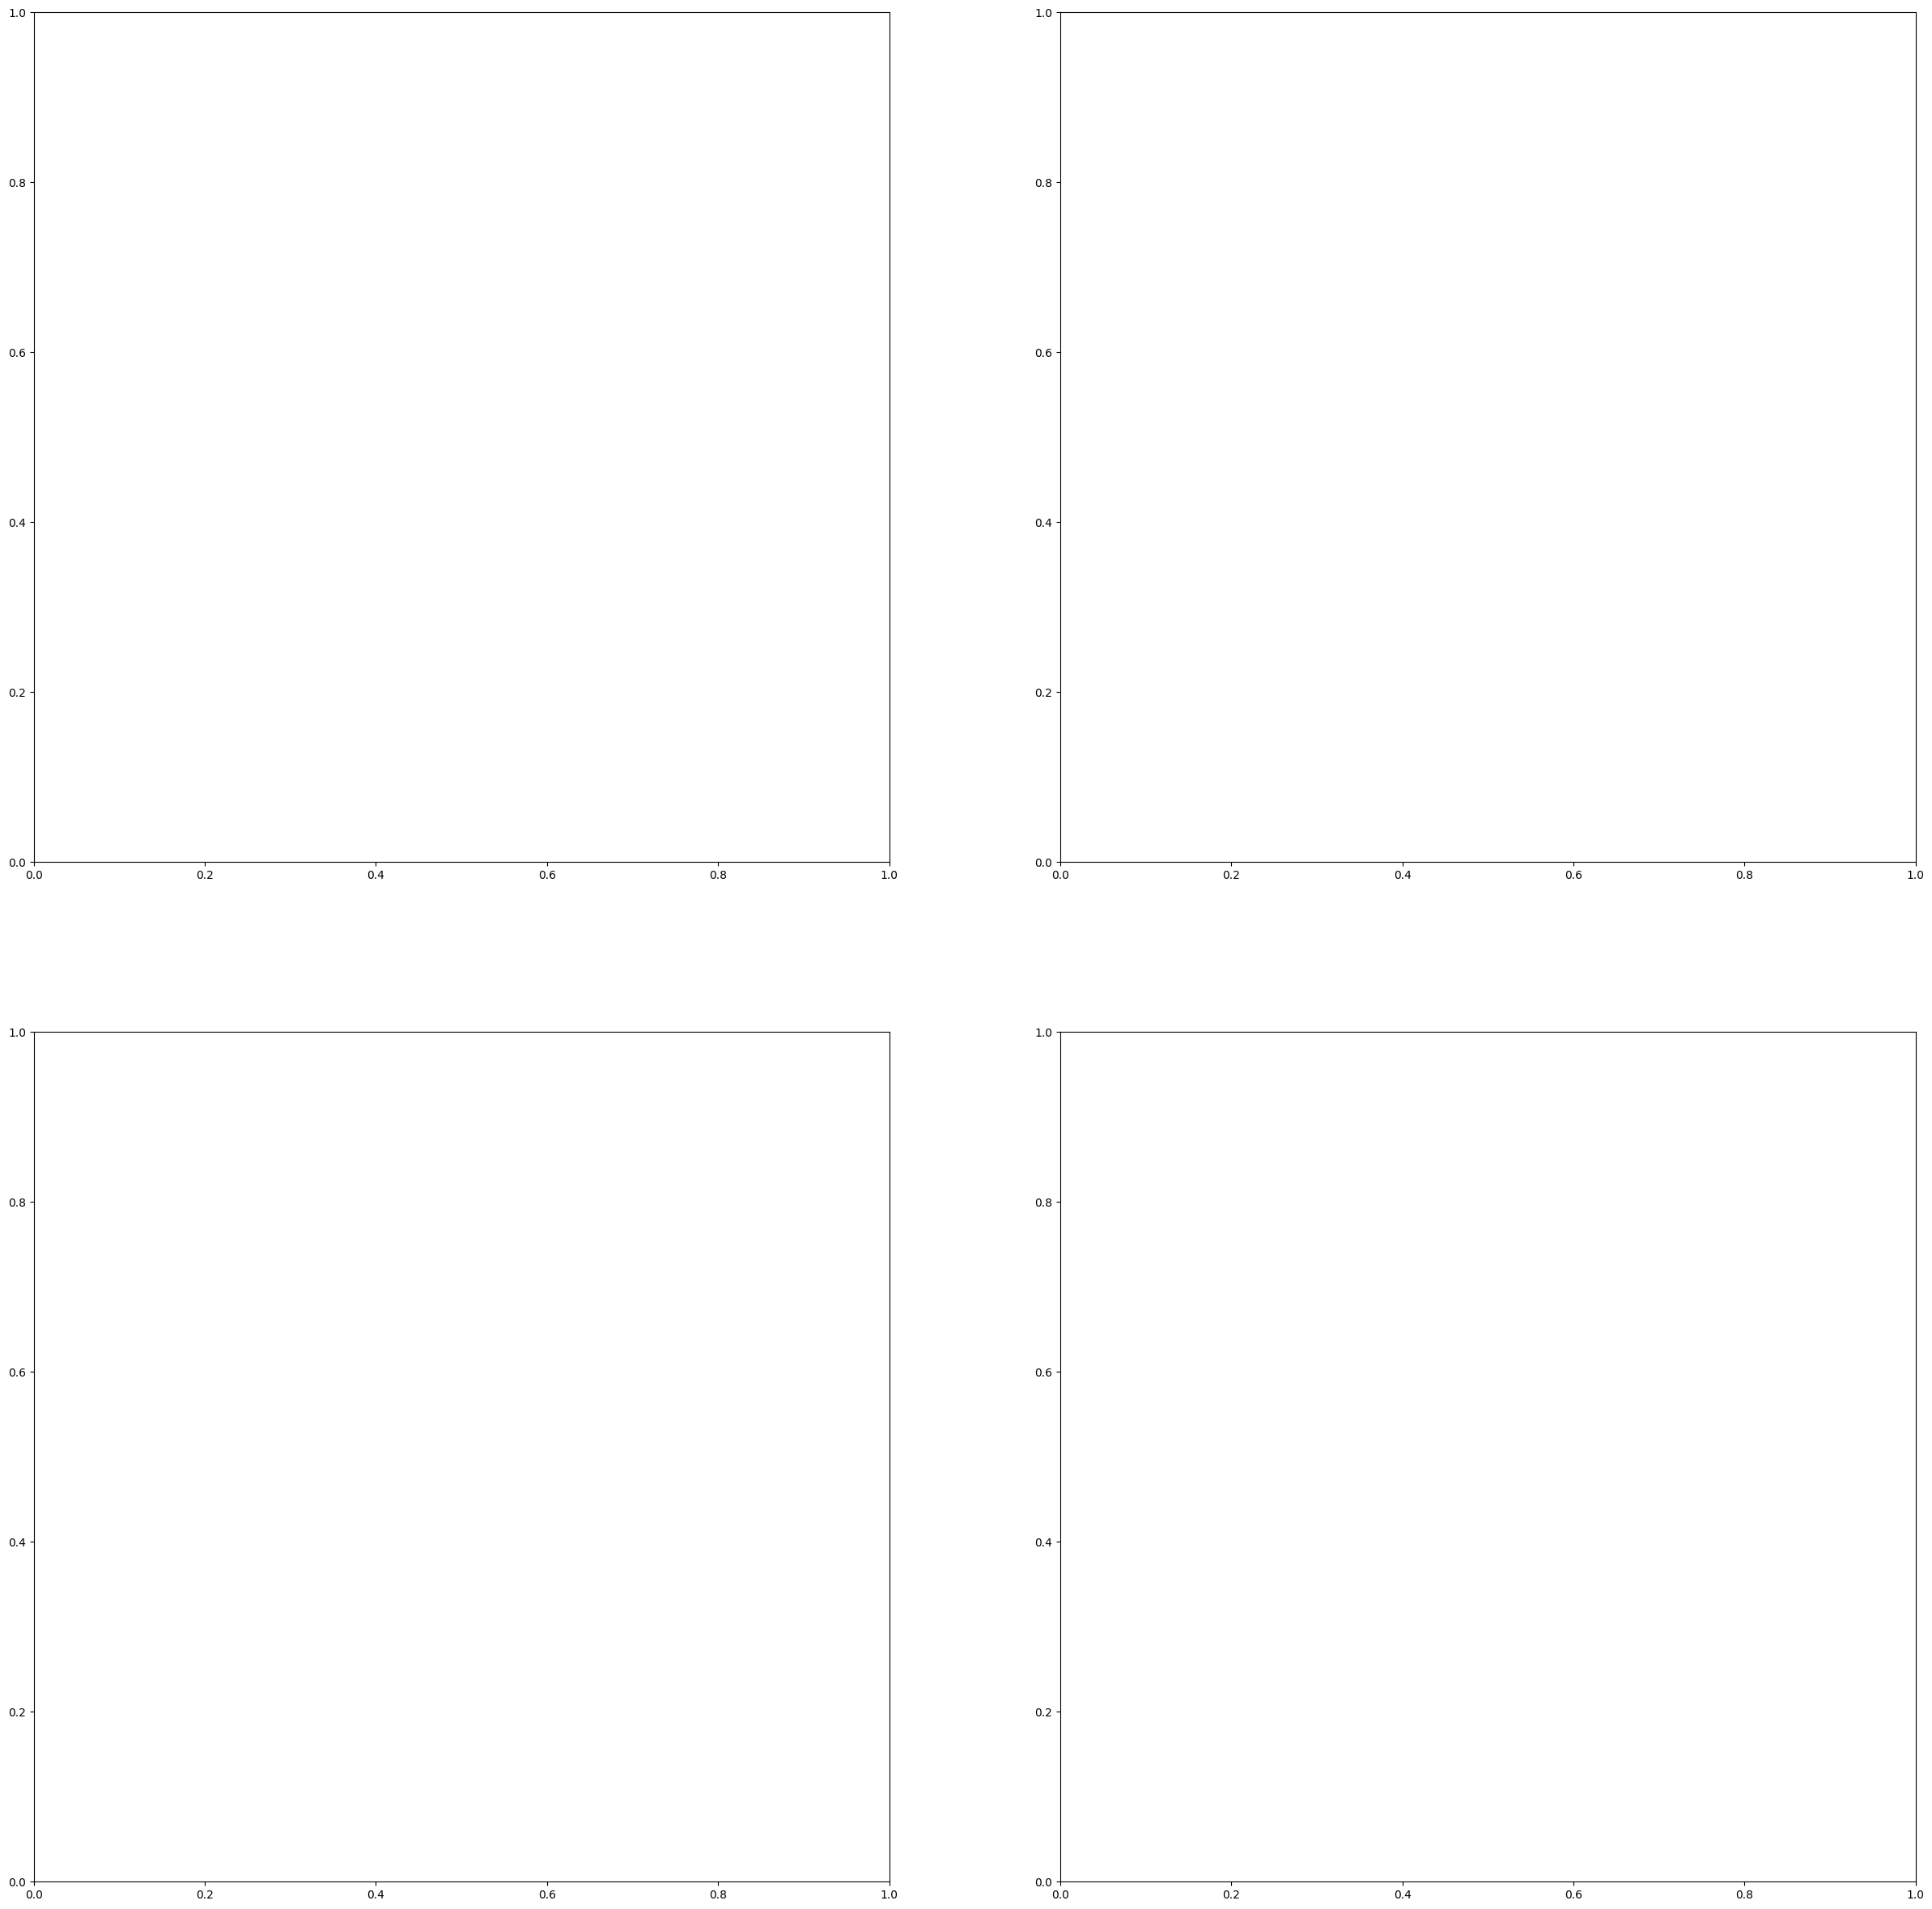

In [5]:
# temp
import matplotlib.pyplot as plt
import cv2

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(30, 30))
[ax.axis("off") for ax in np.ravel(axes)]

content_images = [cv2.cvtColor(cv2.imread('/content/pokemon.jpg'), cv2.COLOR_BGR2RGB)]
style_images = [cv2.cvtColor(cv2.imread('/content/pokemon.jpg'), cv2.COLOR_BGR2GRAY)]
for (axis, content_image, style_image) in zip(axes, content_images, style_images):
    (ax_content, ax_style) = axis
    ax_content.imshow(content_image)
    ax_content.set_title("Content Image")
    ax_style.imshow(style_image, cmap='gray', vmin=0, vmax=255)
    ax_style.set_title("Style Image")